## Basic QPE
- This is an implementation of the vanilla QPE circuit 
- It tries to generalize the circuit for an arbitrary precision circuit returned to the user
- Requirements are the Unitary matrix and precision 

In [2]:
from qiskit import * 
import matplotlib.pyplot as plt 
from qiskit.extensions import UnitaryGate
from qiskit.circuit import add_control 
from qiskit.tools.visualization import plot_bloch_multivector,plot_histogram
import numpy as np 
import sys  
sys.path.append("..")

In [3]:
from Modules.vanilla_qpe import QPE 

### Testing 1 qubit unitaries
- The gate used for determination of phase is the phase gate with a 
    $$ \theta = \frac{1}{5}$$
- Upto 4 bit precision, 1/5 is represented as : 
$$ \theta = 0.0011 $$

$$Unitary = \begin{bmatrix} 1 & 0 \\ 0 & e^{2 \pi i (\frac{1}{5})} \end{bmatrix}$$

In [23]:
U= UnitaryGate(data = np.array([[1,0],
              [0,np.exp(2*np.pi*1j*(1/5))]]))


Circuit for QFT of 4


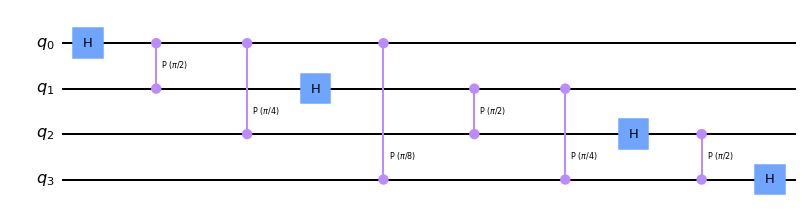

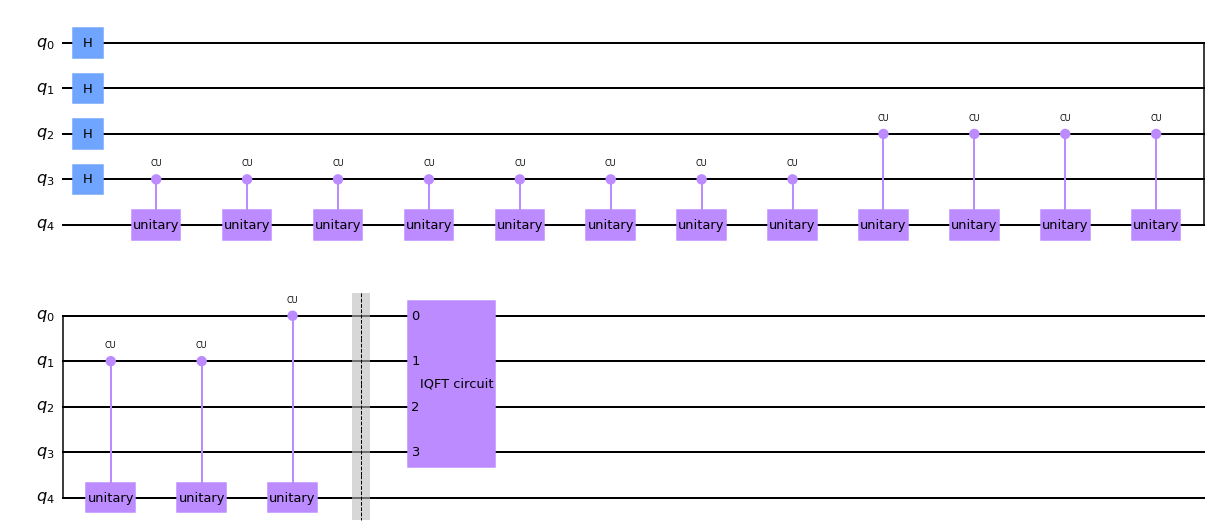

In [24]:
qpe_circ1 = QPE(precision=4,unitary=U).get_QPE(show=True,save = False) 

In [25]:
q = QuantumCircuit(5,4)
q.x(4)
q.barrier()

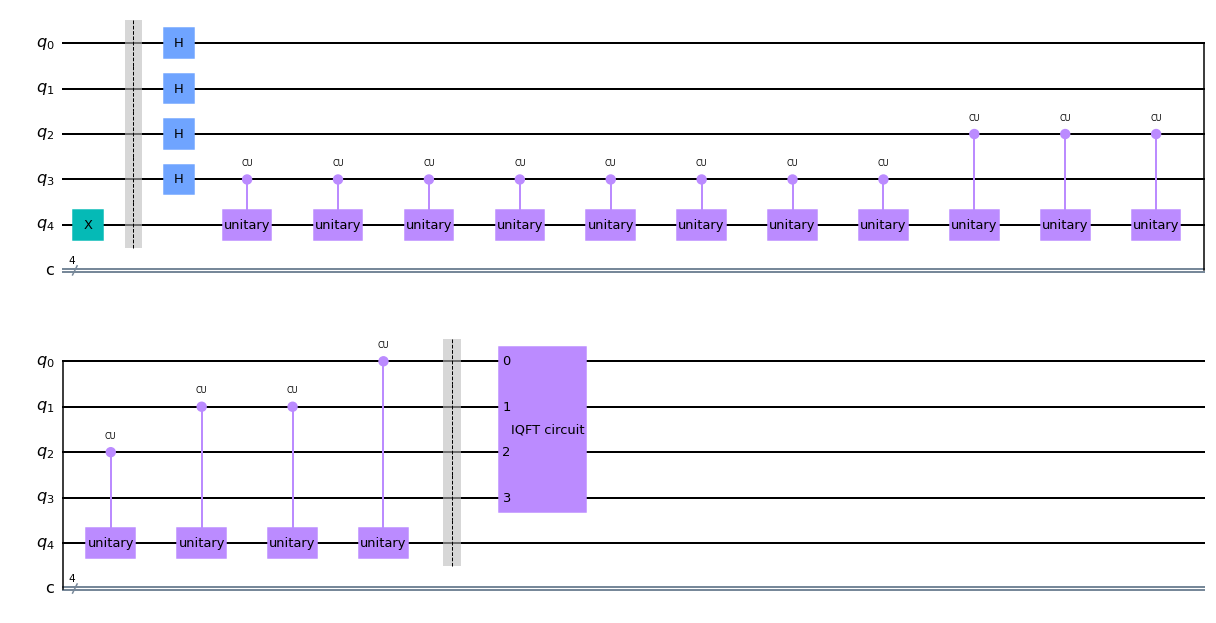

In [26]:
q = q.compose(qpe_circ1,qubits = [0,1,2,3,4])
q.draw('mpl')

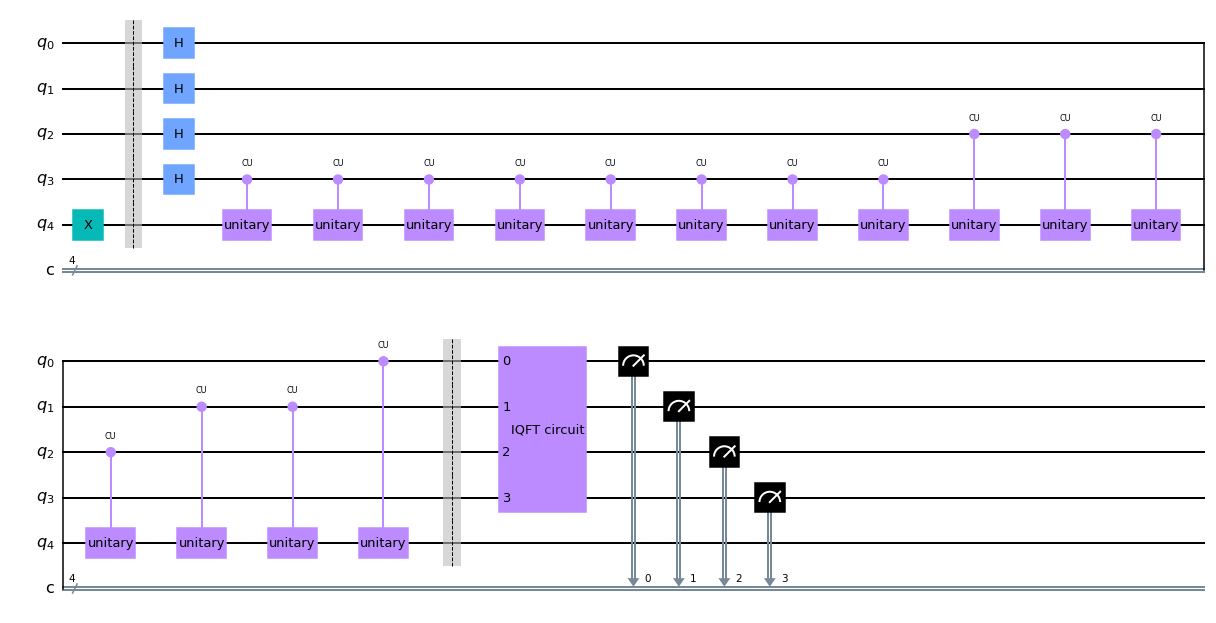

In [27]:
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

- **Visualizing and interpreting the results**

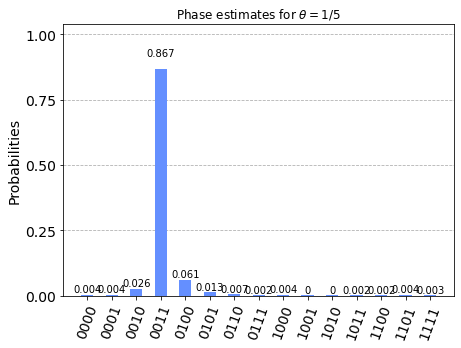

In [28]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
fig = plot_histogram(count,title = "Phase estimates for $\\theta = 1/5$")
fig.savefig("Phase 0.2 estimate.JPG",dpi = 200)
fig 

- These high probability results are reasonably good estimates of the current qpe implementaion using arbitrary Unitary

## Testing 3 qubit circuit
- Using a 2 qubit CP gate with $\theta = \frac {1}{5} $ is used to estimate the phase of the 2 qubit unitary
- Again, the phase is represented upto 4 bit precision as : 
$$\theta = 0.0011$$

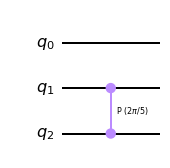

In [29]:
q = QuantumCircuit(3,name = 'Unitary')
q.cp(2*np.pi*(1/5),1,2)
q.draw('mpl')

Circuit for QFT of 4


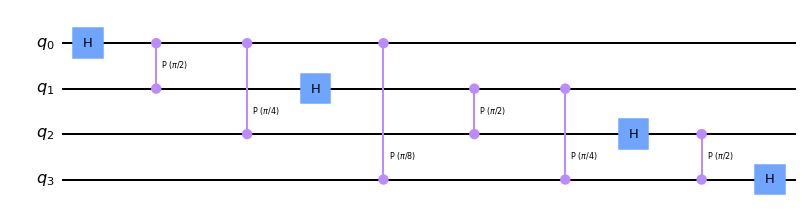

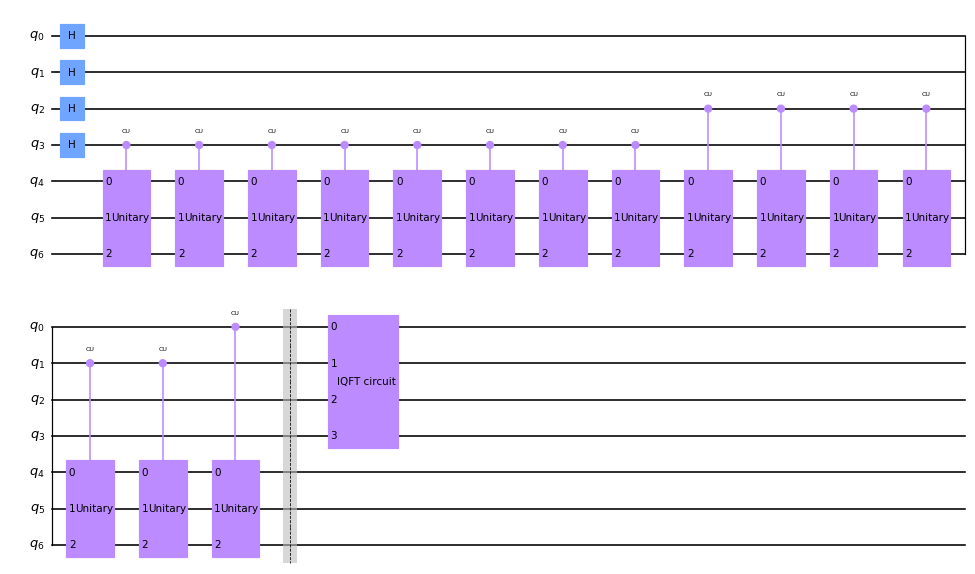

In [30]:
qpe_circ2 = QPE(precision=4,unitary=q).get_QPE(show=True,save=True)

## Attaching the Circuit
- Using the eigenvector $|011 \rangle$ to generate the phase kickback in the Quantum Circuit

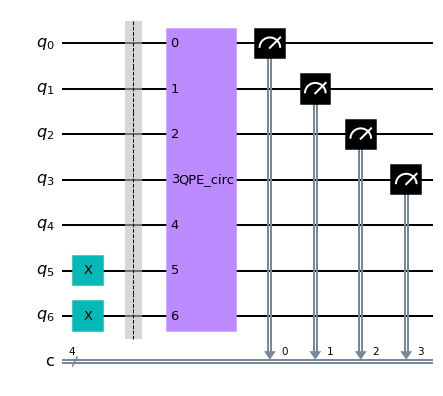

In [31]:
q = QuantumCircuit(7,4)
q.x([5,6])
q.barrier()
q.append(qpe_circ2, qargs = [0,1,2,3,4,5,6])
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

- **Visualizing the Results**

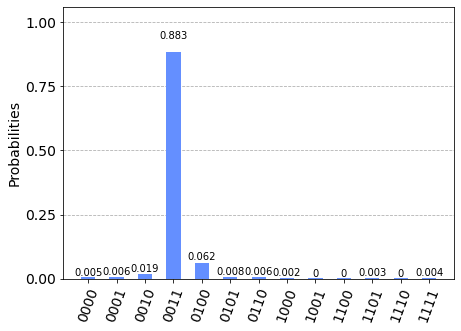

In [32]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)

## Arbitrary placement of Circuit
- Highlights the fact that the circuit can be placed as a sub-routine for an eigenvector in the current QuantumCircuit

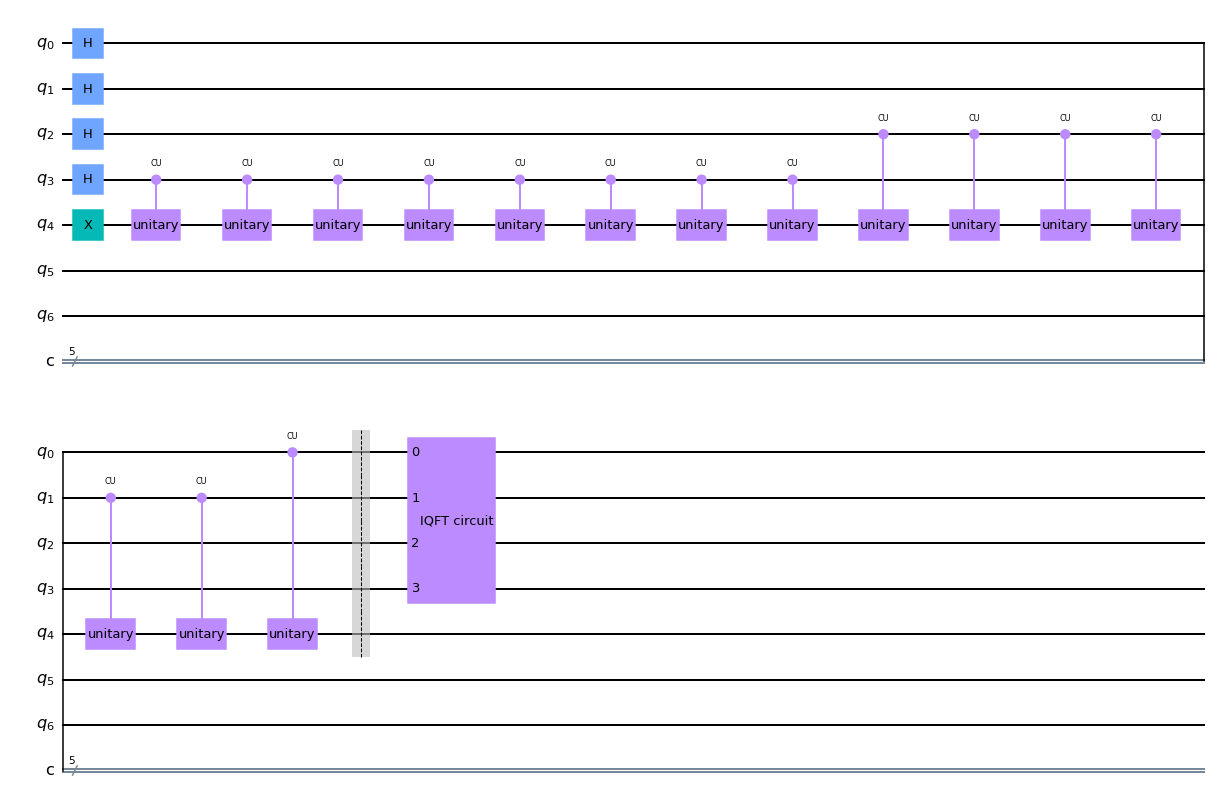

In [33]:
q = QuantumCircuit(7,5)
q.x(4)
q.compose(qpe_circ1,qubits = [0,1,2,3,4], inplace = True)
# q = q.compose(qpe_circ,qubits = [0,1,2,3,4])
q.draw('mpl')

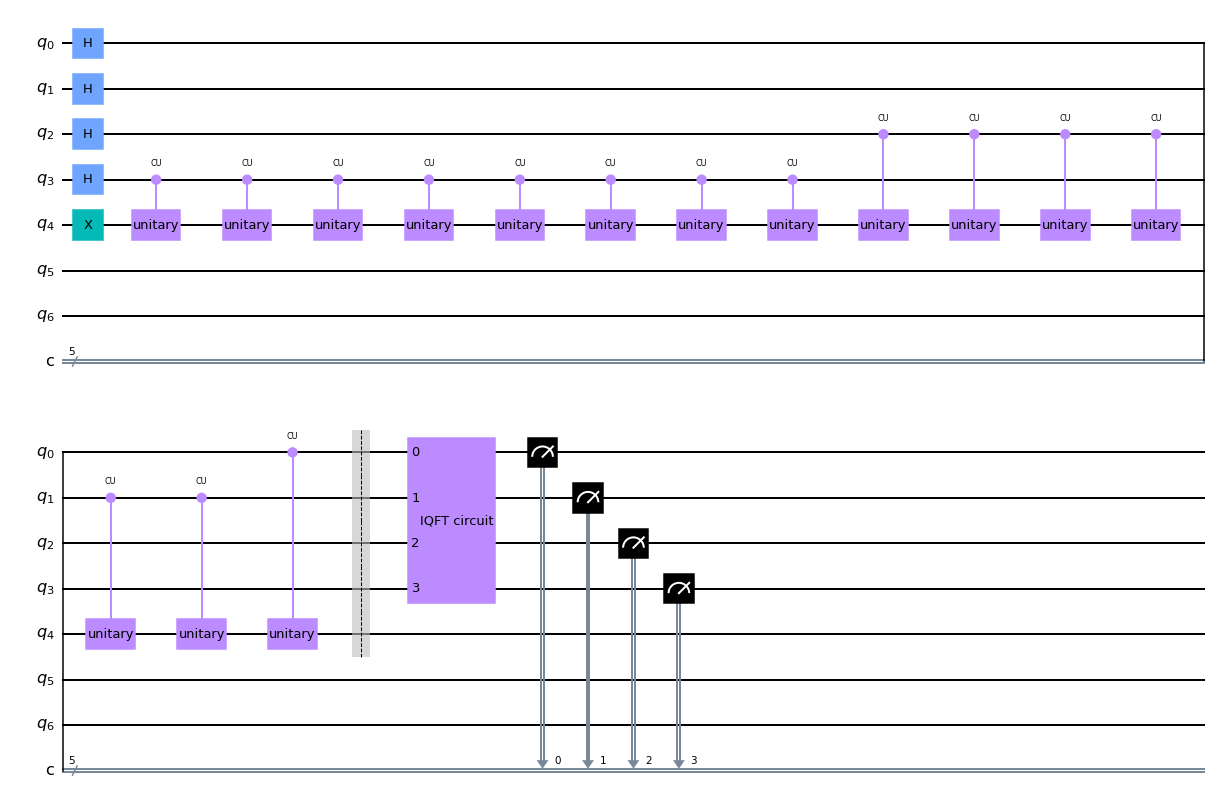

In [34]:
q.measure([0,1,2,3],[0,1,2,3])
q.draw('mpl')

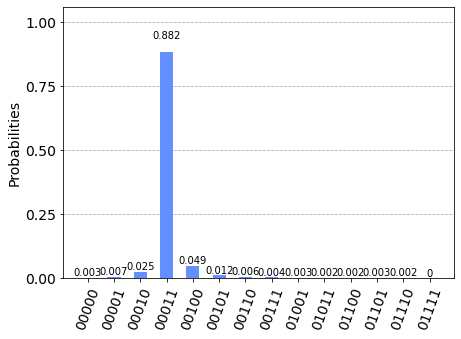

In [35]:
count = execute(q,backend=Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(count)